In [44]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import electric_rates as er
import solar
from vehicles import vehicle_ev, vehicle_ice, gas_costs_per_month, electr_cost_per_month

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
gas_costs = np.linspace(2.00, 4.00, 10)

erates = er.elect_rates()
erates.add_sdge_tou_ev_rates()
miles_per_month = 15000.0/12.0

## Cars
volt = vehicle_ev("Volt 2016", 0.37)
grand_vitara = vehicle_ice("grand vitara", 19, 23, average_override=21)
mazda_3 = vehicle_ice("Mazda 3 2.5l", 28, 39 )
sienna = vehicle_ice("Sienna", 19,25)
gti = vehicle_ice( "GTI", 25,33 )

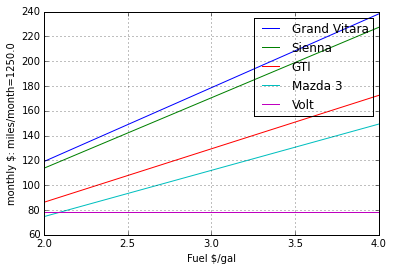

In [46]:
gv_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, grand_vitara.get_ave_mpg() )
mazda_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, mazda_3.get_ave_mpg() )
sienna_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, sienna.get_ave_mpg() )
gti_costs_monthly = gas_costs_per_month( miles_per_month, gas_costs, gti.get_ave_mpg() )
volt_costs_monthly = electr_cost_per_month( miles_per_month, erates.get_ave_rate(), volt.kwh_per_mile )
plt.plot(gas_costs, gv_costs_monthly, label="Grand Vitara")
plt.plot(gas_costs, sienna_costs_monthly, label="Sienna")
plt.plot(gas_costs, gti_costs_monthly, label="GTI")
plt.plot(gas_costs, mazda_costs_monthly, label="Mazda 3")
plt.plot(gas_costs, [volt_costs_monthly]*gas_costs.shape[0], label="Volt" )
plt.xlabel("Fuel $/gal")
plt.ylabel("monthly $: miles/month="+str(miles_per_month))
plt.legend()
plt.grid()
plt.show()

In [47]:
dt = datetime.datetime( year=2015, month=8, day=1, hour=11)
erates.get_rate(dt)

0.2

In [48]:
#e_daily = pd.read_csv("electric-usage--raw.csv")


In [49]:

eUse=er.elect_use_cost_tou(erates)
eUse.read_sdge_use_csv("electric-usage-oct14_oct15--raw.csv")


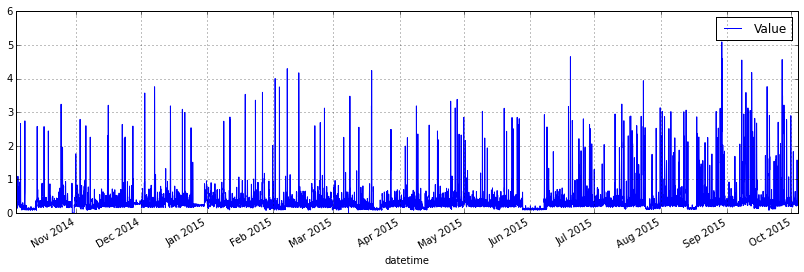

In [50]:

eUse.use_df.plot(x="datetime", y="Value", figsize=(14,4))

In [51]:
#eUse.get_cost()

In [52]:
solar_data = solar.solar_data()

#solar_data.ingest_pvwatts_csv("Solar-calculator--pvwatts_hourly.csv")
#    pd.read_csv("Solar-calculator--pvwatts_hourly.csv",thousands=',')

solar_data.ingest_pvwatts_csv("pvwatts_hourly--v2raw.csv")


In [53]:
#solar_data["datetime"] = solar_data.apply( lambda row:  datetime.datetime( year=2016, month=int(row["Month"]), day=int(row["Day"])
#                                                 , hour=int(row["Hour"]) ), axis=1 )

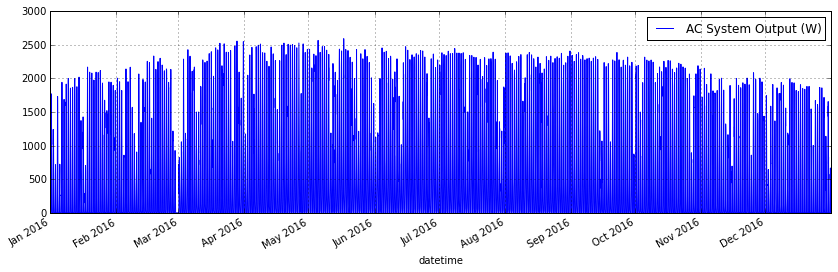

In [54]:
solar_data.data().plot( x="datetime", y="AC System Output (W)",figsize=(14,4))

## Estimated use with EV
### hourly estimate for charging

In [55]:
energy_per_day_kwh = volt.kwh_per_mile * miles_per_month * 12.0/360.0
charge_kw_each_hour_df = volt.get_charge_needs_hourly(energy_per_day_kwh)
#charge_kw_each_hour_df.energy_kw += 1
#print "energy hour==1: "+ str(charge_kw_each_hour_df.loc[charge_kw_each_hour_df["hour"]==1].energy_kw)
#print charge_kw_each_hour_df
#print eUse.use_df.iloc[0]
#print "hour="+ str(eUse.use_df.iloc[0].datetime.hour)
eUse_withcharge = er.elect_use_cost_tou( erates )
eUse_withcharge.load_from_df(eUse.add_use_hourly_dailyrepeat( hourly_use=charge_kw_each_hour_df ))

### hourly estimate for solar credits

In [56]:
#solar_data["AC System Output (W)"]
solar_data_df = solar_data.export_kwatts_for_elect_rates()
solar_eUse = er.elect_use_cost_tou(erates)
solar_eUse.load_from_df(solar_data_df)


## do a per-hour difference of cost vs. generation


In [62]:
print eUse_withcharge.get_cost().cost.sum()
print eUse_withcharge.use_df.Value.sum()

1733.372067
8752.11733333


In [66]:
print "Solar credit $ = "+str(solar_eUse.get_cost().cost.sum())
print "Solar credit kwh =" + str(solar_eUse.use_df.Value.sum())

Solar credit $ = 1360.8695312
Solar credit kwh =4943.106622


In [61]:
print "$/year w/o car="+str(eUse.get_cost().cost.sum())
print "$/year w/ car="+str(eUse_withcharge.get_cost().cost.sum())
print "kwh per year w/o car="+str(eUse.use_df.Value.sum())
print "kwh per year w/ car="+str(eUse_withcharge.use_df.Value.sum())
print "kwh per year for only car="+str( eUse_withcharge.use_df.Value.sum() - eUse.use_df.Value.sum()  )

$/year w/o car=744.084567
$/year w/ car=1733.372067
kwh per year w/o car=3125.034
kwh per year w/ car=8752.11733333
kwh per year for only car=5627.08333333


# FINAL RESULTS

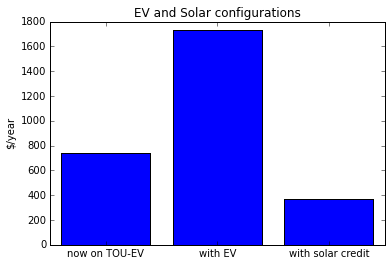

In [85]:
plt.clf()
configs = ('now on TOU-EV','with EV', 'with solar credit')
now = eUse.get_cost()['cost'].sum()
withEv = eUse_withcharge.get_cost()['cost'].sum()
withEvSolar = withEv - solar_eUse.get_cost()['cost'].sum()
values = ( now, withEv, withEvSolar )
y_pos = np.arange(len(configs))
plt.bar( y_pos, values, align='center')
plt.xticks(y_pos, configs)
plt.ylabel('$/year')
plt.title('EV and Solar configurations')
plt.show()

In [76]:
y_pos

array([0, 1, 2])

In [83]:
eUse.get_cost()['cost'].sum()

744.08456699999988

### check energy usage of car

In [60]:
kwh_per_month=volt.kwh_per_mile * miles_per_month
#print "kwh per month="+str(kwh_per_month)
print "kwh per year for car="+str(kwh_per_month*12)

kwh per year for car=5550.0
